# Training and visualization

In [1]:
from collections import namedtuple
from math import ceil

from matplotlib.colors import ListedColormap

from secml.array import CArray
from secml.data.loader import CDLRandom
from secml.data.splitter import CDataSplitter
from secml.figure import CFigure
from secml.ml.classifiers import CClassifierSVM, CClassifierDecisionTree, CClassifierKNN, CClassifierSGD
from secml.ml.classifiers.loss import CLossHinge
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.classifiers.regularizer import CRegularizerL2
from secml.ml.features import CNormalizerMinMax
from secml.ml.peval import CPerfEvaluatorXVal
from secml.ml.peval.metrics import CMetric

In [2]:
random_state = 2134
n_classes = 3
n_features = 2
n_tr = 1000
n_ts = 200
lb = 0.0
ub = 1.0

dataset = CDLRandom(n_classes=n_classes, n_features=n_features, n_informative=n_features, n_redundant=0,
                    n_samples=n_tr + n_ts,
                    n_clusters_per_class=1, class_sep=2,
                    random_state=random_state).load()

idx = CArray.arange(0, dataset.num_samples)

idx.shuffle()
tr = dataset[n_tr:, :]
ts = dataset[:n_ts, :]

# Normalize the data
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X, tr.Y)
ts.X = nmz.transform(ts.X)

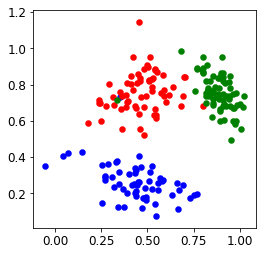

In [3]:
figure = CFigure(width=4, height=4)
colors = list("brgyk")
for c in range(n_classes):
    figure.sp.scatter(ts.X[ts.Y == c, 0], ts.X[ts.Y == c, 1], c=colors[c])
figure.show()

In [4]:
multiclass = CClassifierMulticlassOVA(
    CClassifierSVM, C=1, kernel='rbf')

xval_params = {'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}

In [5]:
xval_splitter = CDataSplitter.create(
    'kfold', num_folds=3, random_state=50000)
best_params = multiclass.estimate_parameters(
    tr, xval_params, xval_splitter, 'accuracy',
    perf_evaluator='xval-multiclass', n_jobs=1)

print(best_params)

# set best parameters and fit
multiclass.set_params(best_params)
multiclass.fit(tr)

perf_eval = CPerfEvaluatorXVal(
    xval_splitter, CMetric.create('accuracy'))
print(perf_eval.compute_performance(multiclass, ts))

{'C': (1, 10, 1), 'kernel.gamma': (0.1, 1, 1)}
0.9699231117141566


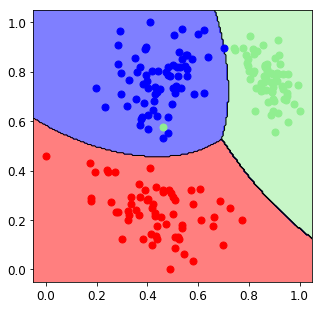

In [6]:
# plot decision function
colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
cmap = ListedColormap(colors[:n_classes])

fig = CFigure(width=5, height=5)

fig.sp.plot_decision_function(multiclass, n_grid_points=200, cmap=cmap)
fig.sp.plot_ds(tr, cmap=cmap)
fig.sp.grid(grid_on=False)

In [7]:
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')
clf_list = [
    CLF(
        clf_name='SVM Linear',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [1, 10, 100]}),
    CLF(clf_name='SVM Rbf',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}),
    CLF(clf_name='KNN',
        clf=CClassifierMulticlassOVA(CClassifierKNN),
        xval_parameters={'n_neighbors': [1, 3, 5]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierMulticlassOVA(CClassifierDecisionTree),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='SGD Linear',
        clf=CClassifierMulticlassOVA(CClassifierSGD, regularizer=CRegularizerL2(),
                                     loss=CLossHinge(), kernel='linear'),
        xval_parameters={'alpha': [0.01, 0.1, 1]}),
    CLF(clf_name='SGD RBF',
        clf=CClassifierMulticlassOVA(CClassifierSGD, regularizer=CRegularizerL2(),
                                     loss=CLossHinge(), kernel='rbf'),
        xval_parameters={'alpha': [0.01, 0.1, 1]}),
]

Classifier:           SVM Linear	Accuracy:0.94
Classifier:              SVM Rbf	Accuracy:0.97
Classifier:                  KNN	Accuracy:0.97
Classifier:        Decision Tree	Accuracy:0.94
Classifier:           SGD Linear	Accuracy:0.95
Classifier:              SGD RBF	Accuracy:0.97


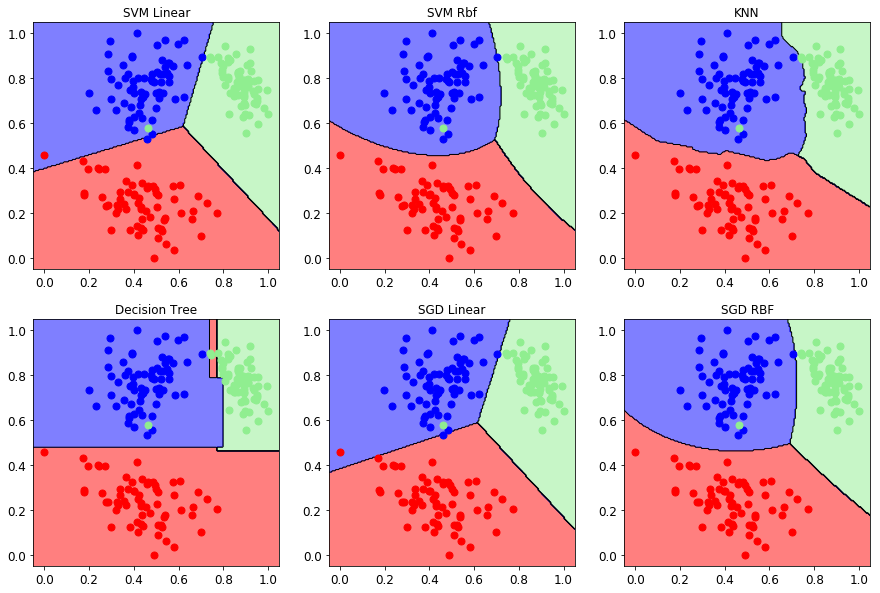

In [8]:
fig = CFigure(width=5 * len(clf_list)/2, height=5*2)

for clf_idx in range(len(clf_list)):
    clf = clf_list[clf_idx].clf
    xval_params = clf_list[clf_idx].xval_parameters
    xval_splitter = CDataSplitter.create(
        'kfold', num_folds=3, random_state=50000)

    best_params = clf.estimate_parameters(
        tr, xval_params, xval_splitter, 'accuracy',
        perf_evaluator='xval-multiclass', n_jobs=1)

    # set best parameters and fit
    clf.set_params(best_params)
    clf.fit(tr)

    perf_eval = CPerfEvaluatorXVal(
        xval_splitter, CMetric.create('accuracy'))
    print("Classifier: %20s\tAccuracy:%.2f" % 
          (clf_list[clf_idx].clf_name, 
           perf_eval.compute_performance(clf, ts)))

    # plot decision function
    colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
    cmap = ListedColormap(colors[:n_classes])

    fig.subplot(2, int(ceil(len(clf_list)/2)), clf_idx + 1)
    fig.sp.title(clf_list[clf_idx].clf_name)
    fig.sp.plot_decision_function(clf, n_grid_points=200, cmap=cmap)
    fig.sp.plot_ds(tr, cmap=cmap)
    fig.sp.grid(grid_on=False)

fig.show()